## <u>*Classsification Modelling for Veh_Body as a Target Feature*</u>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from datetime import datetime,time
import os

In [2]:
df=pd.read_csv(r"C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/Data_Sets/new_cleaned_df.csv")

In [3]:
df.drop(["clm"],axis=1,inplace=True)

In [4]:
from sklearn.metrics import (
    r2_score,accuracy_score,roc_auc_score,auc,roc_curve,precision_score,
    recall_score,precision_recall_curve,r2_score,classification_report,RocCurveDisplay,
    confusion_matrix,f1_score,ConfusionMatrixDisplay
    )
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBRFClassifier
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score,KFold
import warnings                                  
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,StandardScaler
from tqdm import tqdm
from sklearn.utils.multiclass import unique_labels
import plotclassification ,plotly
# import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport

---

In [5]:
df["numclaims"]=df["numclaims"].astype("object")
df["agecat"]=df["agecat"].astype("object")
df["veh_age"]=df["veh_age"].astype("object")

*Date preprocessing*

In [6]:
categories_encoder=LabelEncoder()
for col in df:
    if col in list(df.select_dtypes(include="object").columns):
        df[col]=categories_encoder.fit_transform(df[col])

In [7]:
df=df[df["claimcst0"]>0]
df.head()

,veh_value,exposure,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat,severity,frequincy,pure_premium
14,1660.0,0.484600,1,669.509999,9,2,1,1,5,670.0,2.063559,1381.573600
16,1510.0,0.993840,1,806.609999,9,2,0,5,3,807.0,1.006198,811.609647
17,760.0,0.539357,1,401.805451,3,2,1,2,3,402.0,1.854061,744.971782
40,1890.0,0.654346,2,1811.709997,10,2,1,5,1,906.0,3.056485,2768.732538
64,4060.0,0.851472,1,5434.439987,10,1,1,5,2,5434.0,1.174437,6382.409020


*Define x and y*

In [8]:
x=df.drop("veh_body",axis=1)
y=df["veh_body"]

*apply data balance method*

In [9]:
from imblearn.over_sampling import SMOTE
smk=SMOTE(random_state=41,k_neighbors=1)
x,y=smk.fit_resample(x,y)

*Splitting data into training and testing subsets*

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size= 0.20)

print("Train data shape of X = % s and Y = % s : "%(
	x_train.shape, y_train.shape))

print("Test data shape of X = % s and Y = % s : "%(
	x_test.shape, y_test.shape))

Train data shape of X = (15350, 11) and Y = (15350,) : 
Test data shape of X = (3838, 11) and Y = (3838,) : 


*Data Scaling*

In [11]:
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.transform(x_test)

In [12]:
models = {
                "RandomForestClassifier": RandomForestClassifier(),
                "DecisionTreeClassifier": DecisionTreeClassifier(),
                "XGBRFClassifier": XGBRFClassifier(),
                "GradientBoostingClassifier":GradientBoostingClassifier(),
                "AdaBoostClassifier": AdaBoostClassifier()
                
            }

params={        
                "RandomForestClassifier":{
                    "n_estimators":[90,100,110], 
                    "min_samples_split":[2,4,6],
                    "min_samples_leaf":[0.8,1],
                    "bootstrap":[True, False],                                                                                                    
                    "max_features":["sqrt","log2"],                                     
                    "max_depth":[2,3,4],
                    "criterion":['gini', 'entropy', 'log_loss']
                    },

                "DecisionTreeClassifier": {
                    'criterion':['gini', 'entropy', 'log_loss'],
                    'splitter': ['best', 'random'],
                    "max_depth":[2,3,4], 
                    "min_samples_split":[2,4,6],
                    "min_samples_leaf":[0.5,0.8],
                    "max_features":['sqrt','log2'], 
                },
                "XGBRFClassifier":{
                    'learning_rate': [0.3,.5,1],    # 0.3 is the default
                    "max_depth":[5,6,7],
                    "subsample":[.8,1],
                    'n_estimators': [90, 100, 110], 
                    'colsample_bytree': [0.5,0.8], 
                    'colsample_bynode': [0.5,0.8],
                    "reg_lambda":[0,1,2],           #L2 regularization term on weights. Increasing this value will make model more conservative
                    "reg_alpha":[0,1,2]             #L1 regularization term on weights. Increasing this value will make model more conservative
                },

                
                "GradientBoostingClassifier":{
                    #'loss':['squared_error', 'huber', 'absolute_error', 'quantile'],
                    'learning_rate': [0.01,0.1,1],
                    'n_estimators': [90, 100, 110],
                    'subsample': [0.8,1],
                    #'criterion':['squared_error', 'friedman_mse'],
                    'min_samples_split': [2, 4, 6],
                    'min_samples_leaf': [0.8, 1],
                    'max_depth':[2,3,4],
                    'max_features': ['sqrt', 'log2']
                },
                "AdaBoostClassifier":{
                    'n_estimators': [45,50,55],
                    'learning_rate': [0.01,0.1,1]              
                }
                
            }

In [13]:
def evaluate_models(x_train,y_train,x_test,y_test,models,params):            
                report = {}
                #report2={}
                for i in tqdm(range(len(list(models)))):
                    model=list(models.values())[i]
                    para=params[list(models.keys())[i]]

                    RandomSearchCV=RandomizedSearchCV(model,param_distributions= para,cv=3)
                    RandomSearchCV.fit(x_train,y_train)

                    model.set_params(**RandomSearchCV.best_params_)
                    model.fit(x_train,y_train)

                    y_train_prediction=model.predict(x_train)
                    y_test_prediction=model.predict(x_test)

                    model_train_accuracy_score=accuracy_score(y_train,y_train_prediction)
                    model_test_accuracy_score=accuracy_score(y_test,y_test_prediction)

                    model_train_r2_score=r2_score(y_train,y_train_prediction)
                    model_test_r2_score=r2_score(y_test,y_test_prediction)

                    #report[list(models.keys())[i]] = model_train_mean_absolute_percentage_error
                    report[list(models.keys())[i]] = (model_train_accuracy_score,model_test_accuracy_score,
                                                      RandomSearchCV.best_params_)


                return report

In [ ]:
model_report:dict=evaluate_models(x_train, y_train, x_test, y_test,models=models,params=params)

In [104]:
model_report

{'RandomForestClassifier': (0.4699674267100977,
  0.4585721730067744,
  {'n_estimators': 110,
   'min_samples_split': 4,
   'min_samples_leaf': 1,
   'max_features': 'sqrt',
   'max_depth': 3,
   'criterion': 'gini',
   'bootstrap': True}),
 'DecisionTreeClassifier': (0.13035830618892508,
  0.13574778530484627,
  {'splitter': 'best',
   'min_samples_split': 6,
   'min_samples_leaf': 0.5,
   'max_features': 'sqrt',
   'max_depth': 2,
   'criterion': 'log_loss'}),
 'XGBRFClassifier': (0.8085993485342019,
  0.7720166753517457,
  {'subsample': 1,
   'reg_lambda': 1,
   'reg_alpha': 1,
   'n_estimators': 100,
   'max_depth': 7,
   'learning_rate': 0.5,
   'colsample_bytree': 0.8,
   'colsample_bynode': 0.8}),
 'GradientBoostingClassifier': (0.8056677524429967,
  0.7655028660760813,
  {'subsample': 0.8,
   'n_estimators': 90,
   'min_samples_split': 4,
   'min_samples_leaf': 1,
   'max_features': 'sqrt',
   'max_depth': 3,
   'learning_rate': 0.1}),
 'AdaBoostClassifier': (0.2502931596091205

In [105]:
model_report_df=pd.DataFrame(model_report).iloc[:-1] 

In [106]:
model_report_df

,RandomForestClassifier,DecisionTreeClassifier,XGBRFClassifier,GradientBoostingClassifier,AdaBoostClassifier
0,0.469967,0.130358,0.808599,0.805668,0.250293
1,0.458572,0.135748,0.772017,0.765503,0.249349


In [107]:
model_report_df["metrices"]=["model_train_accuracy_score","model_test_accuracy_score"]

In [108]:
model_report_df

,RandomForestClassifier,DecisionTreeClassifier,XGBRFClassifier,GradientBoostingClassifier,AdaBoostClassifier,metrices
0,0.469967,0.130358,0.808599,0.805668,0.250293,model_train_accuracy_score
1,0.458572,0.135748,0.772017,0.765503,0.249349,model_test_accuracy_score


In [109]:
XGBRFClassifier_best_paramerts=[k[2] for i,k in model_report.items() if i=="XGBRFClassifier"]
XGBRFClassifier_best_paramerts

[{'subsample': 1,
  'reg_lambda': 1,
  'reg_alpha': 1,
  'n_estimators': 100,
  'max_depth': 7,
  'learning_rate': 0.5,
  'colsample_bytree': 0.8,
  'colsample_bynode': 0.8}]

In [110]:
model=XGBRFClassifier(
    subsample=1,
    reg_lambda=1,
    reg_alpha=1,
    n_estimators= 100,
    max_depth= 7,
    learning_rate=0.5,
    min_samples_split= 2,
    colsample_bytree=0.8,
    colsample_bynode=0.8).fit(x_train,y_train)

In [111]:
predicted=model.predict(x_test)

In [112]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       273
           1       0.99      1.00      1.00       308
           2       0.74      0.96      0.84       295
           3       0.64      0.54      0.59       289
           4       0.74      0.64      0.69       309
           5       0.88      1.00      0.94       301
           6       0.77      0.97      0.86       297
           7       0.71      0.82      0.76       293
           8       0.98      1.00      0.99       295
           9       0.46      0.40      0.43       287
          10       0.75      0.36      0.49       314
          11       0.70      0.82      0.76       283
          12       0.70      0.54      0.61       294

    accuracy                           0.77      3838
   macro avg       0.76      0.77      0.76      3838
weighted avg       0.76      0.77      0.76      3838



In [113]:
unique_labels(y_test)
labels=unique_labels(y_test)
col_names=[f"predicted{label}"for label in labels ]
index_names=[f"Actual{label}"for label in labels ]
pd.DataFrame(confusion_matrix(y_test, predicted),columns=col_names,index=index_names)

,predicted0,predicted1,predicted2,predicted3,predicted4,predicted5,predicted6,predicted7,predicted8,predicted9,predicted10,predicted11,predicted12
Actual0,273,0,0,0,0,0,0,0,0,0,0,0,0
Actual1,0,308,0,0,0,0,0,0,0,0,0,0,0
Actual2,0,0,283,4,0,0,1,0,0,4,1,0,2
Actual3,7,0,18,157,5,2,9,19,0,47,1,13,11
Actual4,5,1,9,4,197,6,25,15,2,20,13,10,2
Actual5,0,0,0,0,0,301,0,0,0,0,0,0,0
Actual6,5,0,0,0,0,0,289,0,0,0,0,0,3
Actual7,0,0,27,9,3,0,2,240,0,3,1,7,1
Actual8,0,0,0,0,0,0,0,0,295,0,0,0,0
Actual9,5,0,22,47,13,4,11,22,0,115,12,13,23


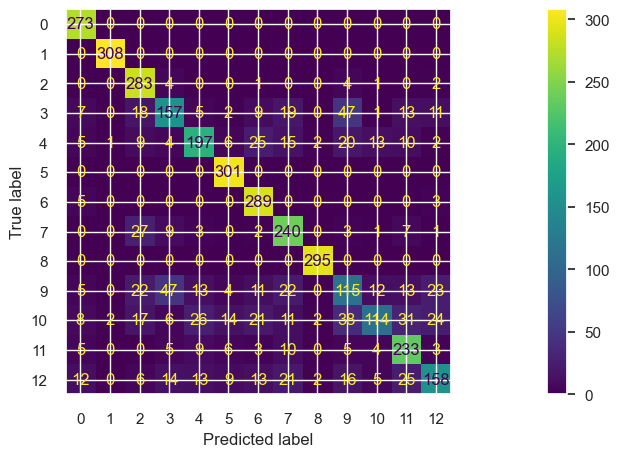

In [114]:
matplotlib.rcParams["figure.figsize"]=(25,5)
ConfusionMatrixDisplay(confusion_matrix(y_test,predicted)).plot()

In [115]:
from sklearn.multiclass import OneVsRestClassifier

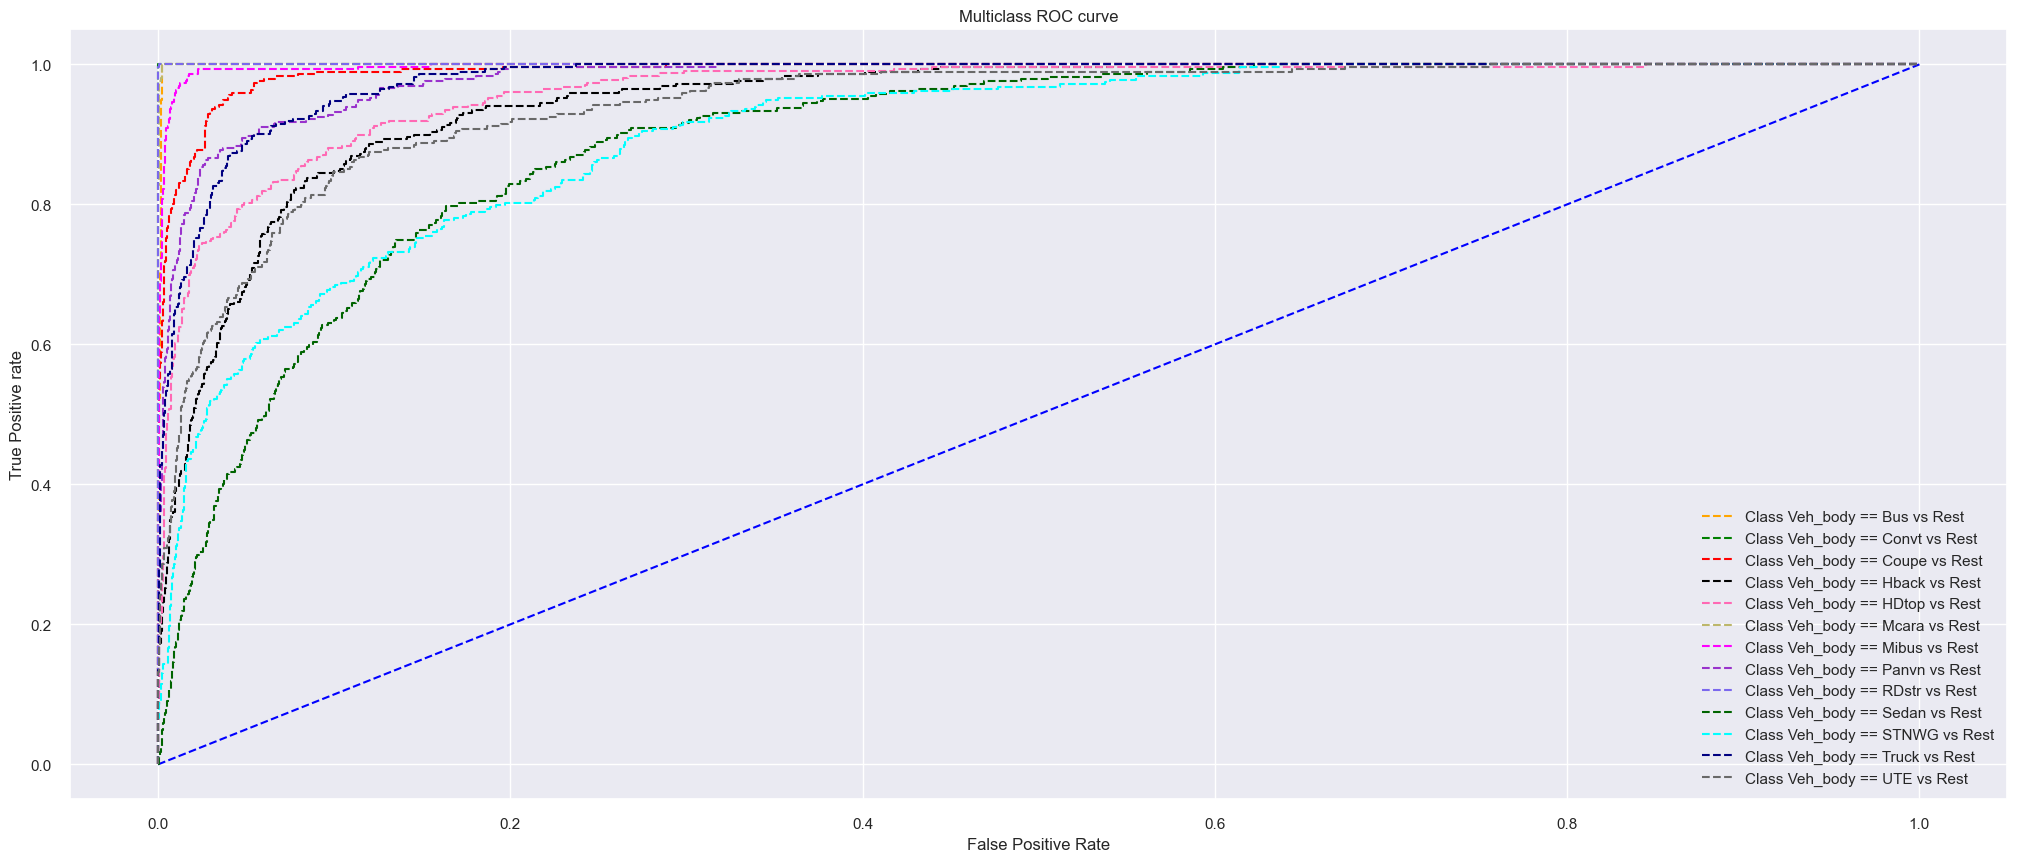

In [116]:
matplotlib.rcParams["figure.figsize"]=(25,10)
clf = OneVsRestClassifier(XGBRFClassifier(
                            subsample=1,
                            reg_lambda=1,
                            reg_alpha=1,
                            n_estimators= 100,
                            max_depth= 7,
                            learning_rate=0.5,
                            min_samples_split= 2,
                            colsample_bytree=0.8,
                            colsample_bynode=0.8)).fit(x_train,y_train)


clf.fit(x_train, y_train)
pred = clf.predict(x_test)
pred_prob = clf.predict_proba(x_test)

# roc curve for classes
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 13

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class Veh_body == Bus vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class Veh_body == Convt vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='red', label='Class Veh_body == Coupe vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='black', label='Class Veh_body == Hback vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='HotPink', label='Class Veh_body == HDtop vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='DarkKhaki', label='Class Veh_body == Mcara vs Rest')
plt.plot(fpr[6], tpr[6], linestyle='--',color='Magenta', label='Class Veh_body == Mibus vs Rest')
plt.plot(fpr[7], tpr[7], linestyle='--',color='DarkOrchid', label='Class Veh_body == Panvn vs Rest')
plt.plot(fpr[8], tpr[8], linestyle='--',color='MediumSlateBlue', label='Class Veh_body == RDstr vs Rest')
plt.plot(fpr[9], tpr[9], linestyle='--',color='DarkGreen', label='Class Veh_body == Sedan vs Rest')
plt.plot(fpr[10], tpr[10], linestyle='--',color='Aqua', label='Class Veh_body == STNWG vs Rest')
plt.plot(fpr[11], tpr[11], linestyle='--',color='Navy', label='Class Veh_body == Truck vs Rest')
plt.plot(fpr[12], tpr[12], linestyle='--',color='DimGray', label='Class Veh_body == UTE vs Rest')

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
#plt.savefig('Multiclass ROC',dpi=300); 
plt.show()


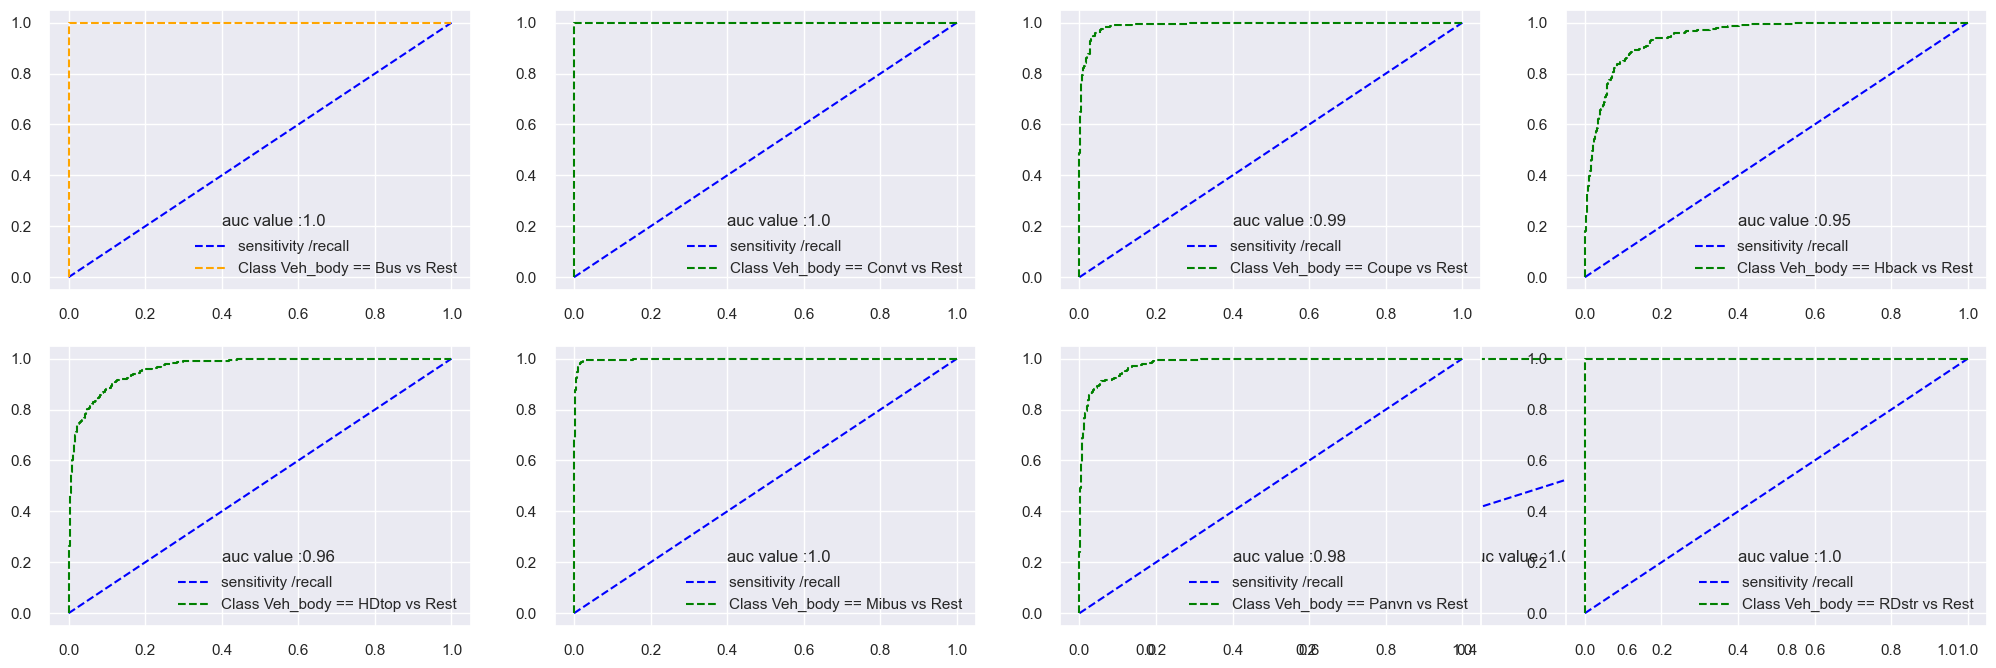

In [117]:
matplotlib.rcParams["figure.figsize"]=(25,8)
plt.subplot(241)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[0], tpr[0]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Bus vs Rest'])

plt.subplot(242)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[1], tpr[1]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Convt vs Rest'])

plt.subplot(243)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[2], tpr[2], linestyle='--',color='green')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[2], tpr[2]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Coupe vs Rest'])

plt.subplot(244)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[3], tpr[3], linestyle='--',color='green')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[3], tpr[3]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Hback vs Rest'])

plt.subplot(245)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[4], tpr[4], linestyle='--',color='green')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[4], tpr[4]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == HDtop vs Rest'])

plt.subplot(224)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[5], tpr[5], linestyle='--',color='green')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[5], tpr[5]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Mcara vs Rest'])

plt.subplot(246)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[6], tpr[6], linestyle='--',color='green')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[6], tpr[6]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Mibus vs Rest'])


plt.subplot(247)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[7], tpr[7], linestyle='--',color='green')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[7], tpr[7]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Panvn vs Rest'])

plt.subplot(248)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[8], tpr[8], linestyle='--',color='green')
plt.text(0.4,0.2, f'auc value :{round(auc(fpr[8], tpr[8]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == RDstr vs Rest'])

plt.show()

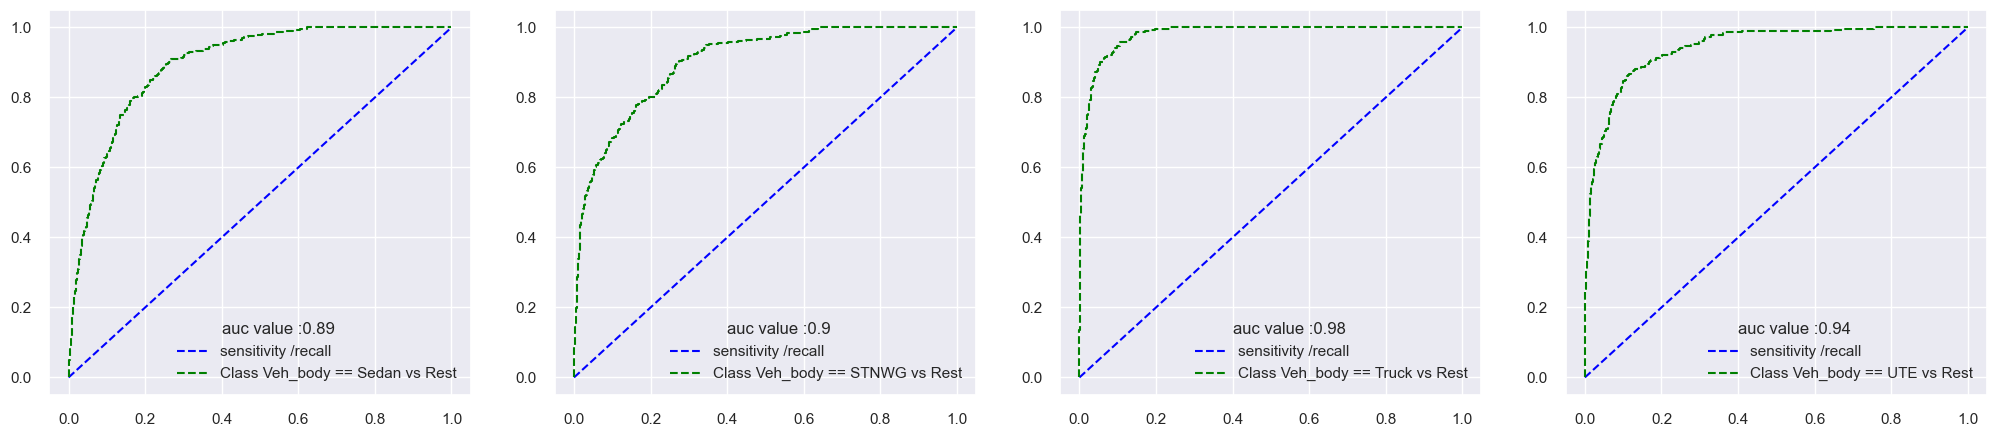

In [118]:
matplotlib.rcParams["figure.figsize"]=(25,5)
plt.subplot(141)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[9], tpr[9], linestyle='--',color='green')
plt.text(0.4,0.125, f'auc value :{round(auc(fpr[9], tpr[9]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Sedan vs Rest'])

plt.subplot(142)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[10], tpr[10], linestyle='--',color='green')
plt.text(0.4,0.125, f'auc value :{round(auc(fpr[10], tpr[10]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == STNWG vs Rest'])


plt.subplot(143)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[11], tpr[11], linestyle='--',color='green')
plt.text(0.4,0.125,f'auc value :{round(auc(fpr[11], tpr[11]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == Truck vs Rest'])


plt.subplot(144)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[12], tpr[12], linestyle='--',color='green')
plt.text(0.4,0.125, f'auc value :{round(auc(fpr[12], tpr[12]),2)}')
plt.legend(['sensitivity /recall','Class Veh_body == UTE vs Rest'])

plt.show()

In [137]:
importance=pd.concat([pd.DataFrame(df.drop("veh_body",axis=1).columns,columns=["feature_names"]),
           pd.DataFrame(model.feature_importances_,columns=["feature_importances"])],axis=1)

In [138]:
importance

,feature_names,feature_importances
0,veh_value,0.115391
1,exposure,0.065181
2,numclaims,0.041727
3,claimcst0,0.061108
4,veh_age,0.184727
5,gender,0.105965
6,area,0.149808
7,agecat,0.063143
8,severity,0.077719
9,frequincy,0.071053


In [139]:
PurePremiumImportanceTabel=importance.sort_values(by='feature_importances',ascending=False)
PurePremiumImportanceTabel.to_pickle("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/App/Feature_importance_Table/Veh_BodyImportanceTabel.pkl")

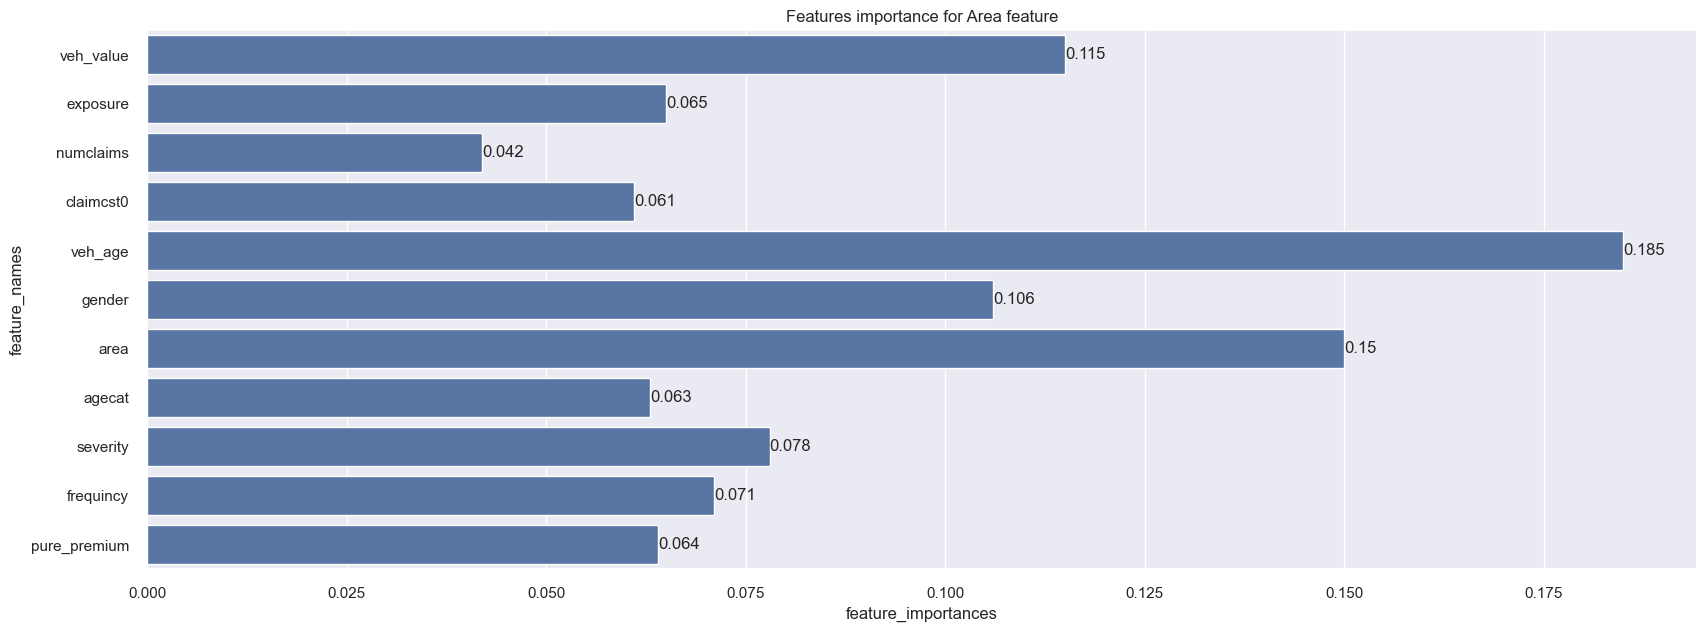

In [140]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for Area feature')
ax.bar_label(ax.containers[0]);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/App/Feature_importance_Graph/Veh_Body_featureImportanc',dpi=500);

In [141]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/final_models/veh_body_prediction_model.pkl","wb") as f:
    pickle.dump(model,f)

---